![Memories Teach](https://lh3.google.com/u/2/d/11o4JyBYhHcmz-LSt63GpOs4lfW9j39T_=w1912-h954-iv1)


`Basic to Advance in Google colab's for image processing, pattern recognition and computer vision`

[Phonepaserth SISAYKEO]

Reference: visioncolab


# Examples of Validation Set Usage

This example shows how to choose the hyperparameter K of the KNN classifier (number of neighbors). The idea is to find the K that maximizes the accuracy in the validation set, as follows:

- The KNN classifier with K neighbors is trained with the training set.

- The accuracy in the validation set is evaluated.

- Repeat the previous steps varying K (e.g. using exhaustive search) in such a way that the accuracy in the validation set is maximized (we will call K_best the value of K found).

- Train the classifier (with the training set) with the chosen K (K_best).

- The accuracy is evaluated in the testing set. This is the value of interest since the classifier is evaluated on a new data set that was neither used to train the classifier, nor to find the best hyperparameters of the classifier.

## Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from   sklearn.neighbors import KNeighborsClassifier
from   sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from   tqdm.auto import tqdm
from   IPython.display import clear_output


## Dataset

In this example we will use the two feature database with Training, Validation and Testing set.

In [ ]:
!wget https://www.dropbox.com/s/pmohi04xnmklpvd/D2_trainvaltest.zip
!unzip -qq D2_trainvaltest.zip

!ls *.npy
print('Datasets D2_trainvaltest loaded.')


--2023-07-18 20:19:57--  https://www.dropbox.com/s/pmohi04xnmklpvd/D2_trainvaltest.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/pmohi04xnmklpvd/D2_trainvaltest.zip [following]
--2023-07-18 20:19:57--  https://www.dropbox.com/s/raw/pmohi04xnmklpvd/D2_trainvaltest.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccdf4b6b7d42fee9c3e9d027f96.dl.dropboxusercontent.com/cd/0/inline/CAFq7vBVCVXGRHqkxTdsmUu9h5h5WqM_l0CGMFthe7X3tUY2uGzpUGLET_6_1fLXLnJRX_8DK8YApKaI1gI_IUO4Q9twQW6vZKiGMwCUfYKi1xsYsWWQfyLVzw8zmrd3ScMuGXOljUtEyIk7c45bTZ6UNs5q-BbFDQgDqC1FKQiUkA/file# [following]
--2023-07-18 20:19:57--  https://uccdf4b6b7d42fee9c3e9d027f96.dl.dropboxusercontent.com/cd/0/inline/CAFq7vBVCVXGRHqkxTdsmUu9h5h5WqM_l0CGMFthe7X3tUY2uGzpUGLET_6

## Functions

In [ ]:
def print_confusion(dt,ds,show_heatmap=0,Cnorm=1):
    # dt - true, ds - predicted
    C   = confusion_matrix(dt,ds)
    print('Confusion Matrix:')
    print(C)
    acc = accuracy_score(dt,ds)
    acc_st = "{:.2f}".format(acc*100)
    print('Accuracy = '+str(acc_st))
    if show_heatmap:
      sns.heatmap(C/Cnorm, annot=True, cbar=None, cmap="Blues")
      plt.title("Confusion Matrix"), plt.tight_layout()
      plt.ylabel("True Class"), plt.xlabel("Predicted Class")
      plt.show()

def plot_features(X,d,st,show=1):
    dmin = int(np.min(d))
    dmax = int(np.max(d))
    #colors = np.array(["red","green","blue","yellow","pink","black","orange","purple","beige","brown","gray","cyan","magenta"])
    #colors = 'Greens'
    for j in range(dmin,dmax+1):
        plt.scatter(X[d==j,0],X[d==j,1],label=str(j),s=27)
    plt.grid(True)
    plt.legend()
    plt.xlabel('$x_1$',fontsize=14)
    plt.ylabel('$x_2$',fontsize=14)
    plt.title('Feature Space - '+st,fontsize=14)
    if show==1:
        plt.show()

def plot_features3(X,d,st,show=1,view=(30,60)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=d, cmap=plt.cm.autumn)
    ax.set_xlabel('$x_1$',fontsize=14)
    ax.set_ylabel('$x_2$',fontsize=14)
    ax.set_zlabel('$x_3$',fontsize=14)
    plt.title('Feature Space - '+st,fontsize=14)
    ax.view_init(view[0],view[1])
    # plt.axis('off')
    # plt.grid(b=None)
    if show == 1:
        plt.show()

def plot_decision_lines(clf,X,show=0,decisionline=1):
    # based on example of https://scikit-learn.org
    h = 0.075
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    if decisionline == 1:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Reds, alpha=0.8)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    if show==1:
        plt.show()

def show_clf_results(clf,X,d,Xt,dt,d0,ds,st,decisionline=1):
    gs = gridspec.GridSpec(1, 2)
    fig = plt.figure(figsize=(18, 6))
    print('Training:')
    acc = accuracy_score(d,d0)
    accst = f'Acc = {acc:.4f}'
    ax = plt.subplot(gs[0,0])
    print_confusion(d,d0)                             # confusion matrix in training
    plot_decision_lines(clf,X,0,decisionline)          # decision lines
    plot_features(X,d,st+' - Training: '+accst,0)     # feature space in training
    ax = plt.subplot(gs[0,1])
    print('Testing:')
    acc = accuracy_score(ds,dt)
    accst = f'Acc = {acc:.4f}'
    print_confusion(dt,ds)                            # confusion matrix in testing
    plot_decision_lines(clf,X,0,decisionline)          # decision lines
    plot_features(Xt,dt,st+' - Testing: '+accst,1)    # feature space in testing


# Training/Validation/Testing Data

Loading npy files...


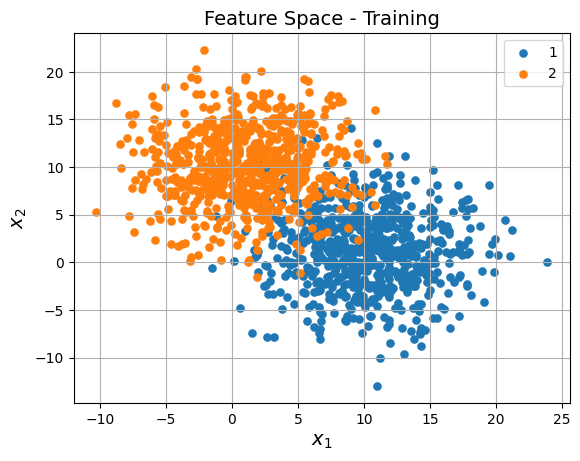

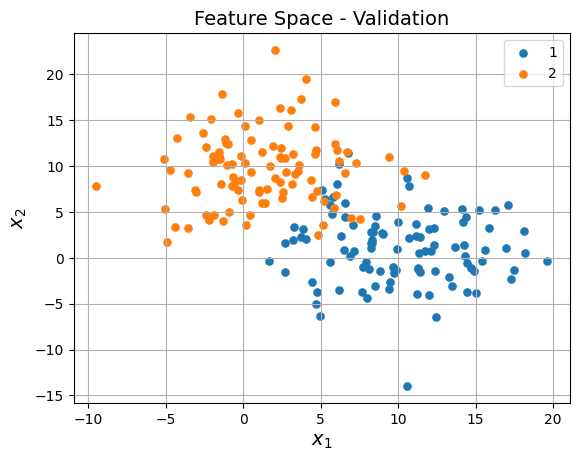

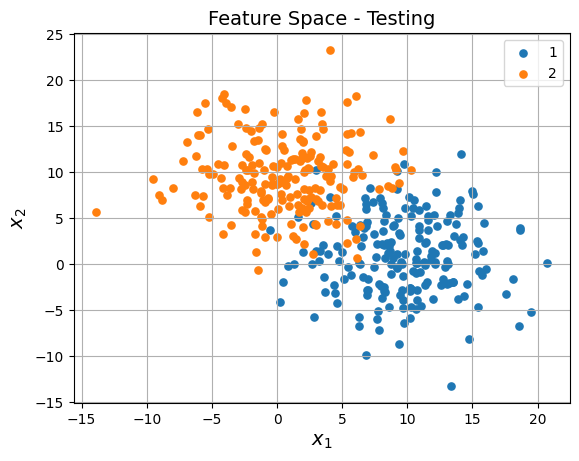

In [ ]:
print('Loading npy files...')

Xtrain = np.load('Xtrain.npy')
Xval   = np.load('Xval.npy')
Xtest  = np.load('Xtest.npy')
ytrain = np.ravel(np.load('ytrain.npy'))
yval   = np.ravel(np.load('yval.npy'))
ytest  = np.ravel(np.load('ytest.npy'))

plot_features(Xtrain,ytrain,'Training')
plot_features(Xval,yval,'Validation')
plot_features(Xtest,ytest,'Testing')


            x_1        x_2  clases
0     11.184685   1.733727       1
1     14.803132  -0.038929       1
2     14.360691  -4.419156       1
3      8.565187  -3.629768       1
4      9.480289  -2.047945       1
...         ...        ...     ...
1395  -0.557363  11.440121       2
1396  -4.086671   1.750862       2
1397   2.090404  12.669419       2
1398   2.269874   8.075547       2
1399   6.993473  13.217313       2

[1400 rows x 3 columns]


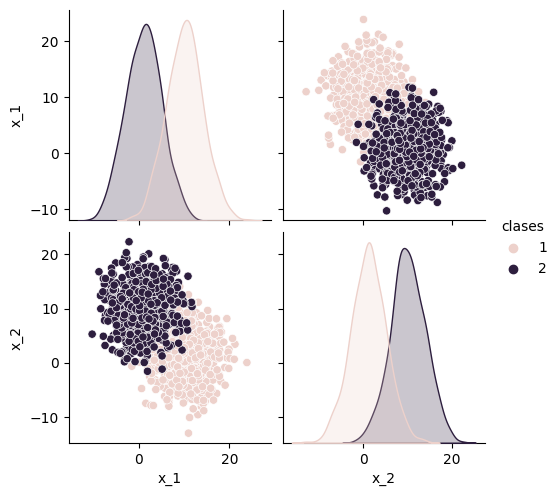

In [ ]:

df1 = pd.DataFrame(Xtrain, columns = ['x_1','x_2'])
df2 = pd.DataFrame(ytrain.astype(int),columns = ['clases'])
df = pd.concat([df1, df2], axis=1)
print(df)
sns.pairplot(df,hue='clases')
#sns.scatterplot(data=df, x="x_1", y="x_2", hue="clases",palette="deep")

# KNN

## KNN - number of neighbors search

Using the validation set the best hyperparameter k (number of neighbors) is searched, that is the number of neighbors of the KNN that maximizes the accuracy in the validation set.

1 > 0.8950 *** max
3 > 0.9200 *** max
4 > 0.9300 *** max


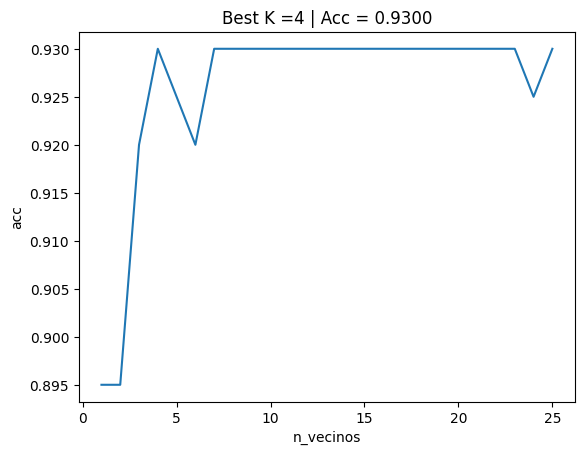

In [ ]:
n = 25
acc_knn = np.zeros((n,))
acc_max = 0
for j in range(n):
  k = j+1
  clf = KNeighborsClassifier(n_neighbors=k)
  clf.fit(Xtrain, ytrain)
  ypred_val    = clf.predict(Xval)
  acc_knn[j]   = accuracy_score(ypred_val,yval)
  if acc_knn[j]>acc_max:
    acc_max = acc_knn[j]
    K_best = k
    acc_st = format(acc_max, ".4f")
    print(str(k)+' > '+acc_st+' *** max')

plt.plot(range(1,n+1),acc_knn)
plt.ylabel('acc')
plt.xlabel('n_vecinos')
plt.title('Best K ='+str(K_best)+' | Acc = '+acc_st)
plt.show()


## KNN

In [ ]:
# 1. Classifier
n_vecinos = K_best
clf = KNeighborsClassifier(n_neighbors=n_vecinos)

# 2. Training
clf.fit(Xtrain, ytrain)

# 3. Testing
ypred_train  = clf.predict(Xtrain)
ypred_val    = clf.predict(Xval)
ypred_test   = clf.predict(Xtest)

# 4. Accuracy
acc_train	 = accuracy_score(ypred_train,ytrain)
acc_val 	 = accuracy_score(ypred_val  ,yval)
acc_test	 = accuracy_score(ypred_test ,ytest)
print('Acc-Train = '+str(acc_train*100)+'%')
print('Acc-Val   = '+str(acc_val*100)+'%')
print('Acc-Test  = '+str(acc_test*100)+'%')

Acc-Train = 95.35714285714286%
Acc-Val   = 93.0%
Acc-Test  = 93.25%


## KNN - Outputs

Training:
Confusion Matrix:
[[673  27]
 [ 38 662]]
Accuracy = 95.36
Testing:
Confusion Matrix:
[[192   8]
 [ 19 181]]
Accuracy = 93.25


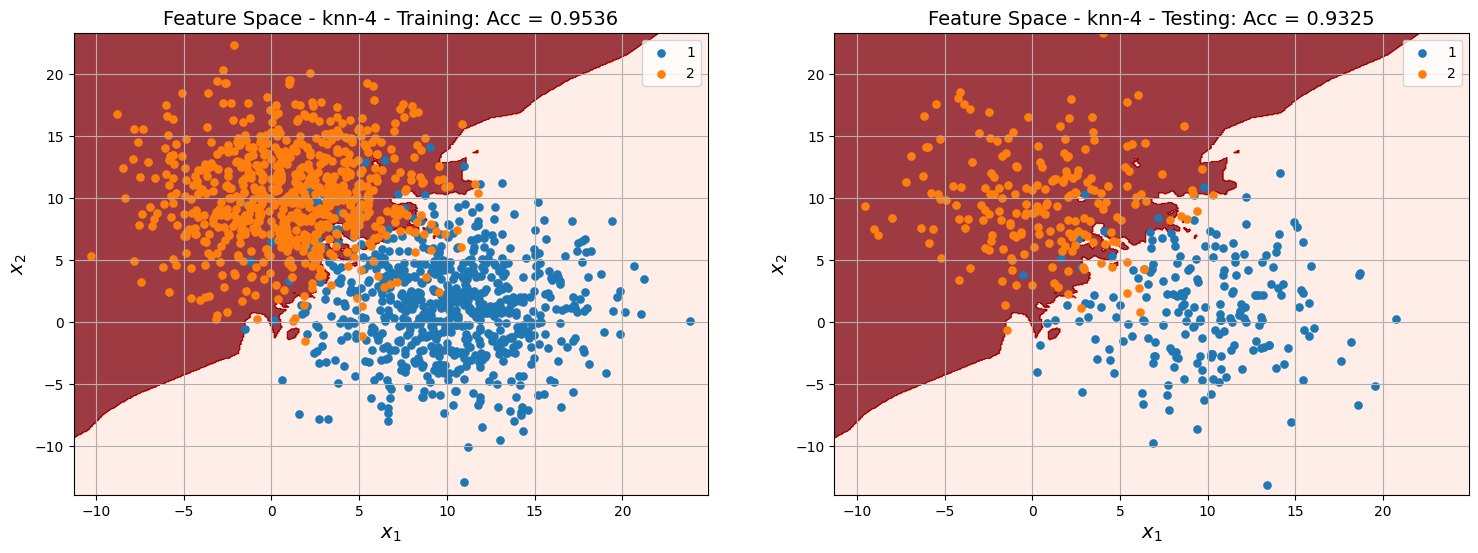

In [ ]:
knn_st = 'knn-'+str(n_vecinos)

show_clf_results(clf,Xtrain,ytrain,
                 Xtest,ytest,ypred_train,ypred_test,knn_st)    # show performance and feature space